# Image Decoder examples

In this notebook we will show usage examples of different flavors of decoders.image.  You will see, that those variants offer the same functionality for CPU backend (`device="cpu"`) and Mixed backend (`device="mixed"` - where the decoding is accelerated by GPU).

Note that we define all the examples to accept the device parameter, so we can later change it easily.

## Common code

First, let's define some common function that allows us to easily show the images.

In [1]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from nvidia.dali.backend import TensorListGPU

%matplotlib inline

seed = 1549361629


def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))


image_dir = "../data/images"
batch_size = 4


def show_pipeline_output(pipeline):
    pipe.build()
    (images,) = pipe.run()
    if isinstance(images, TensorListGPU):
        images = images.as_cpu()
    show_images(images)

## Image Decoder (CPU)

`decoders.image` decodes images stored in common formats (including JPEG, JPEG2000, TIFF, PNG)

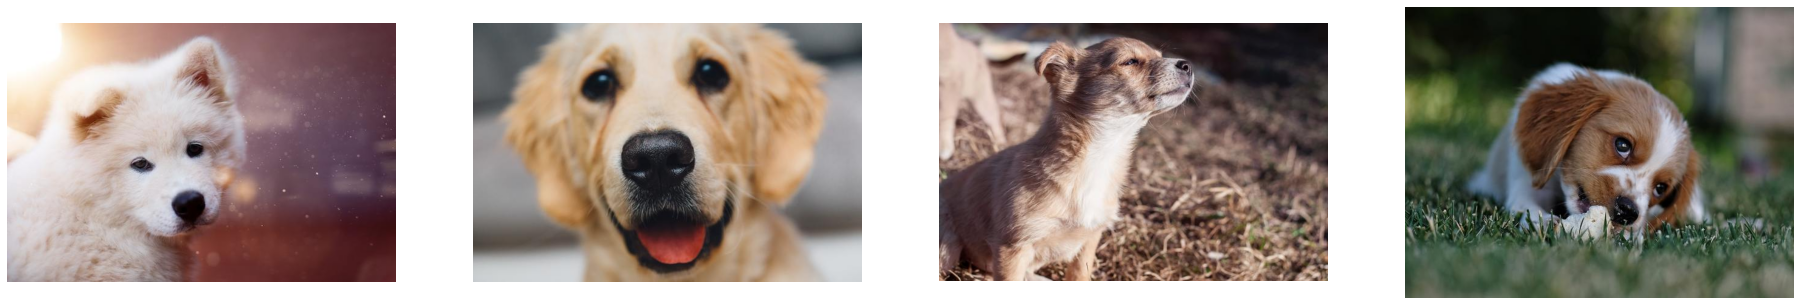

In [2]:
@pipeline_def(seed=seed)
def image_decoder_pipeline(device="cpu"):
    jpegs, labels = fn.readers.file(file_root=image_dir)
    return fn.decoders.image(jpegs, device=device)


pipe = image_decoder_pipeline(batch_size=batch_size, num_threads=1, device_id=0)
show_pipeline_output(pipe)

## Image Decoder (CPU) with Random Cropping Window Size and Anchor

`decoders.image_random_crop` produces a randomly cropped image. The random cropping window is produced based on a given aspect ratio and area distributions.

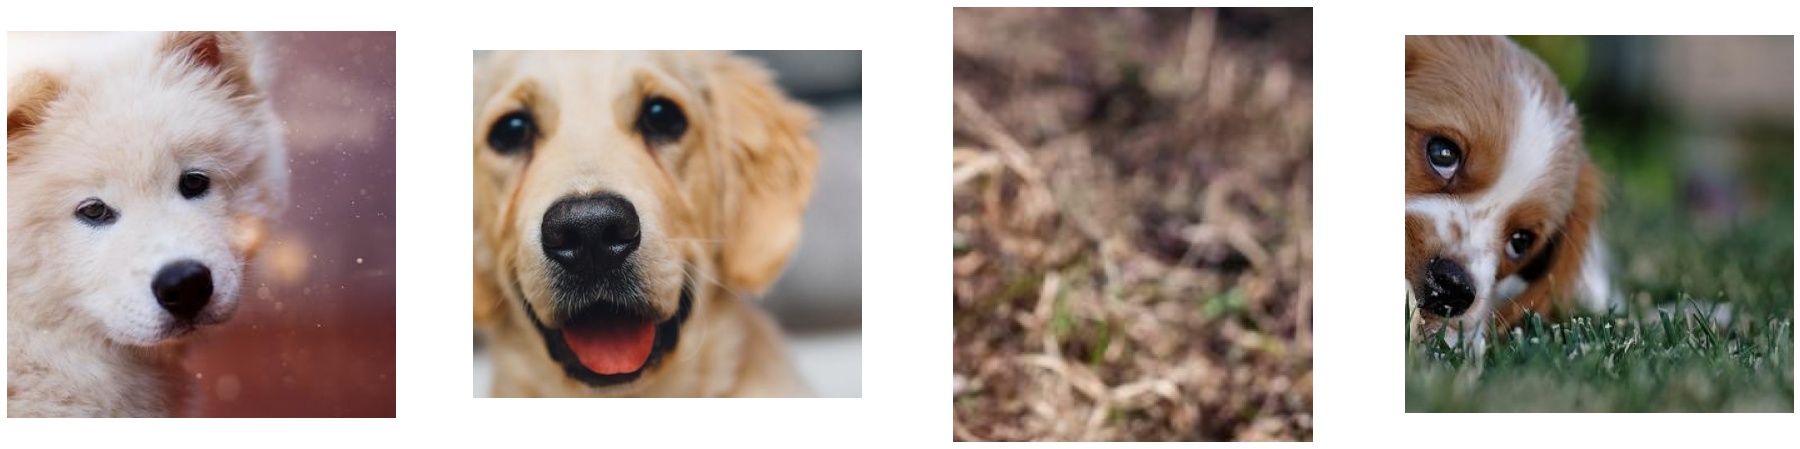

In [3]:
@pipeline_def(seed=seed)
def image_decoder_random_crop_pipeline(device="cpu"):
    jpegs, labels = fn.readers.file(file_root=image_dir)
    images = fn.decoders.image_random_crop(
        jpegs,
        random_aspect_ratio=[0.8, 1.25],
        random_area=[0.1, 1.0],
        num_attempts=100,
        device=device,
    )
    return images


pipe = image_decoder_random_crop_pipeline(batch_size=batch_size, num_threads=1, device_id=0)
show_pipeline_output(pipe)

## Image Decoder with Fixed Cropping Window Size and External Anchor

`decoders.image_crop` produces a cropped image with a fixed cropping window size and a variable position

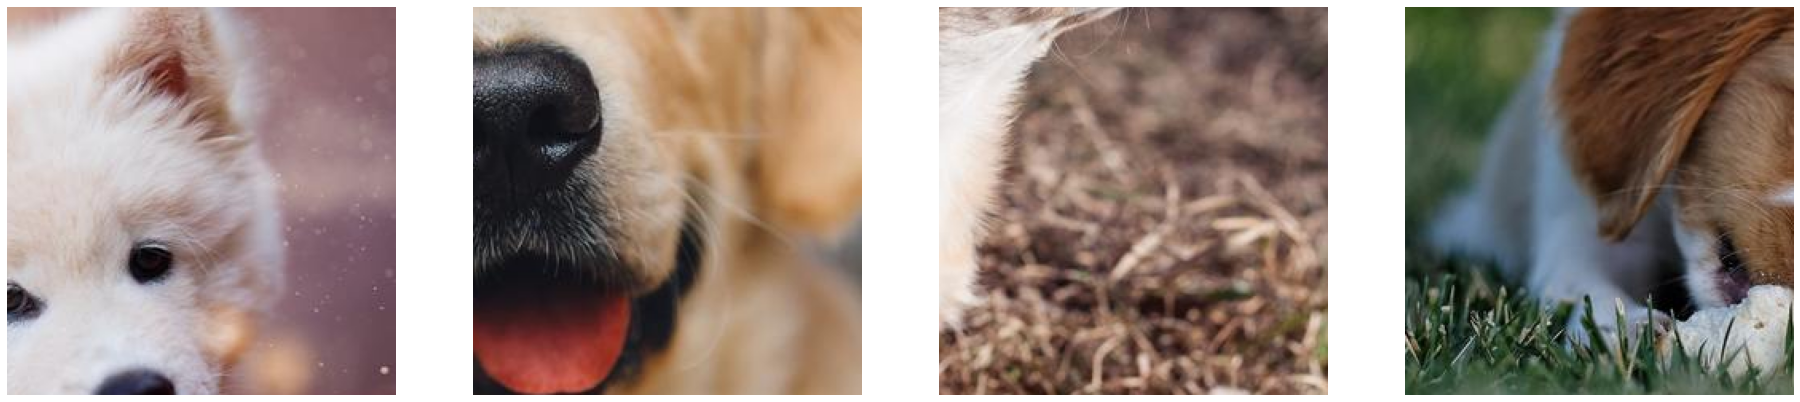

In [4]:
@pipeline_def(seed=seed)
def image_decoder_crop_pipeline(device="cpu"):
    jpegs, labels = fn.readers.file(file_root=image_dir)
    pos_x = fn.random.uniform(range=(0.0, 1.0))
    pos_y = fn.random.uniform(range=(0.0, 1.0))
    return fn.decoders.image_crop(
        jpegs, crop=(244, 244), crop_pos_x=pos_x, crop_pos_y=pos_y, device=device
    )


pipe = image_decoder_crop_pipeline(batch_size=batch_size, num_threads=1, device_id=0)
show_pipeline_output(pipe)

## Image Decoder (CPU) with External Window Size and Anchor

`decoders.image_slice` produces a cropped image based on additional tensor inputs describing the cropping window size and position

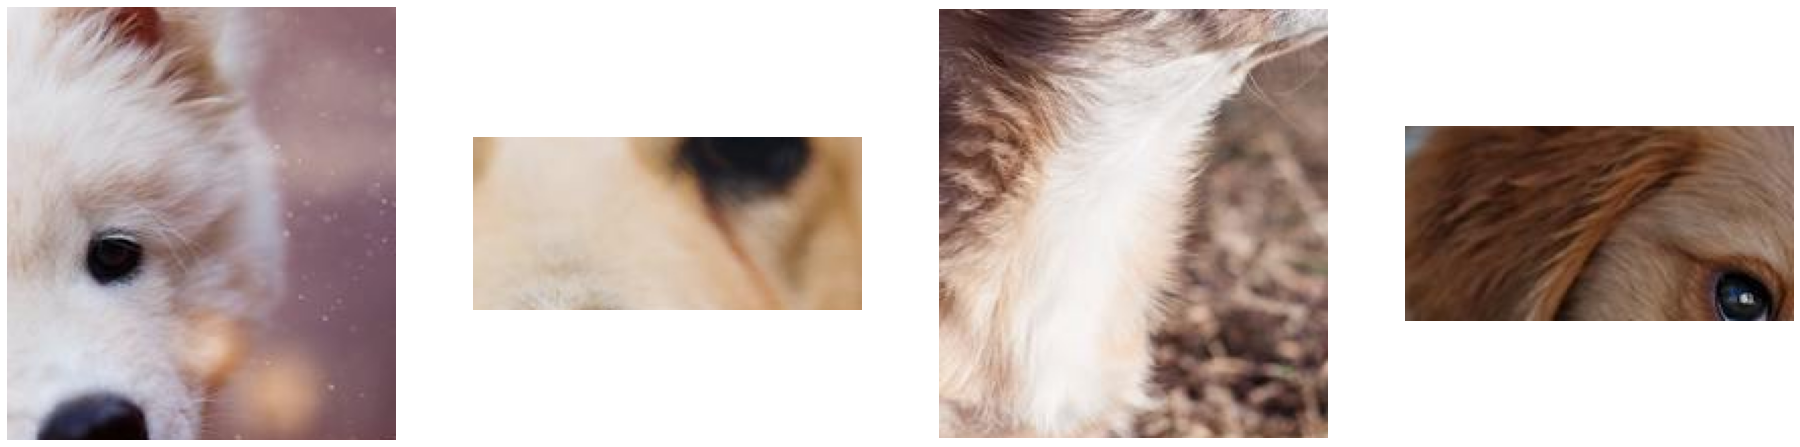

In [5]:
import numpy as np
from itertools import product

pos_source = [[0.4, 0.2], [0.3, 0.3]]
size_source = [[0.3, 0.5], [0.3, 0.2]]


def ext_source_generator():
    for pos, size in product(pos_source, size_source):
        yield np.array(pos, dtype=np.float32), np.array(size, dtype=np.float32)


@pipeline_def(seed=seed)
def image_decoder_slice_pipeline(device="cpu"):
    crop_pos, crop_size = fn.external_source(
        source=ext_source_generator, cycle=True, num_outputs=2, batch=False, dtype=types.FLOAT
    )
    jpegs, labels = fn.readers.file(file_root=image_dir)
    return fn.decoders.image_slice(jpegs, crop_pos, crop_size, device=device)


pipe = image_decoder_slice_pipeline(batch_size=batch_size, num_threads=1, device_id=0)
show_pipeline_output(pipe)

## Image Decoder (Hybrid)

`decoders.image` with mixed backend offloads JPEG decoding to the GPU or a dedicated hardware unit, if present.

Note, that we repeat the examples shown above, changing only the device parameter. Both the operator and its other parameters stay the same and offer the same functionality - but now we use GPU acceleration.

> **_NOTE_**
>
> If you are wondering why the decoder uses the `device="mixed"` instead of `device="gpu"` - it's because it fuses the GPU-decoding with transferring the images from CPU to GPU memory. To learn more about DALI pipeline stages see [pipeline documentation section](../../pipeline.html?#processing-graph-structure).

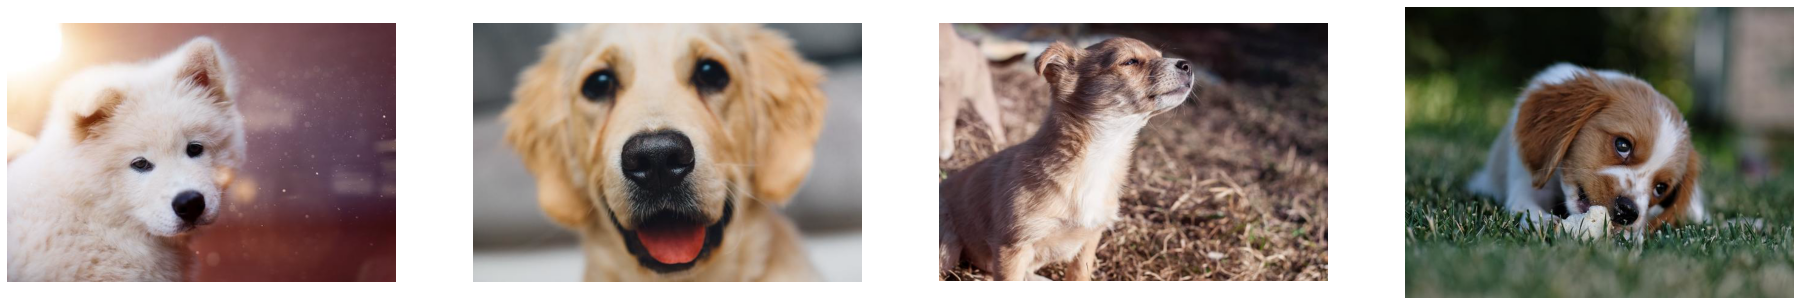

In [6]:
pipe = image_decoder_pipeline(batch_size=batch_size, num_threads=1, device_id=0, device="mixed")
pipe.build()
(images,) = pipe.run()
show_images(images.as_cpu())

## Image Decoder (Hybrid) with Random Cropping Window Size and Anchor

`decoders.image_random_crop` produces a randomly cropped image. The random cropping window is produced based on a given aspect ratio and area distributions.

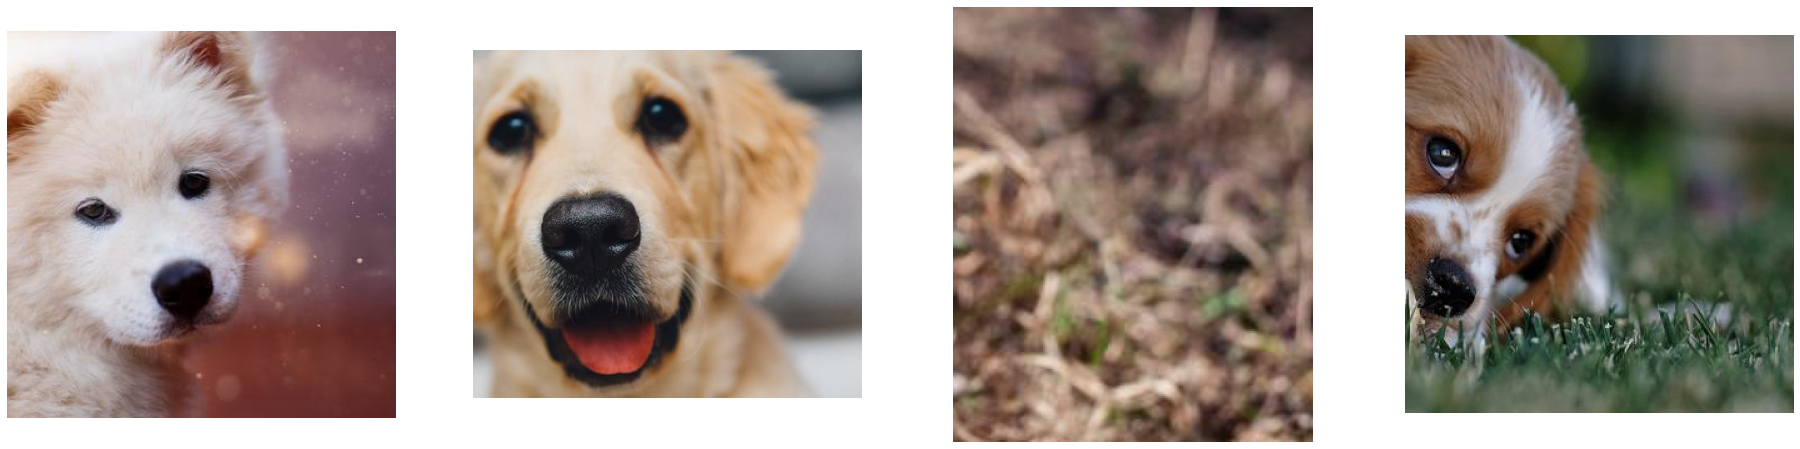

In [7]:
pipe = image_decoder_random_crop_pipeline(
    batch_size=batch_size, num_threads=1, device_id=0, device="mixed"
)
show_pipeline_output(pipe)

## Image Decoder (Hybrid) with Fixed Cropping Window Size and External Anchor

`decoders.image_crop` produces a cropped image with a fixed cropping window size and a variable position


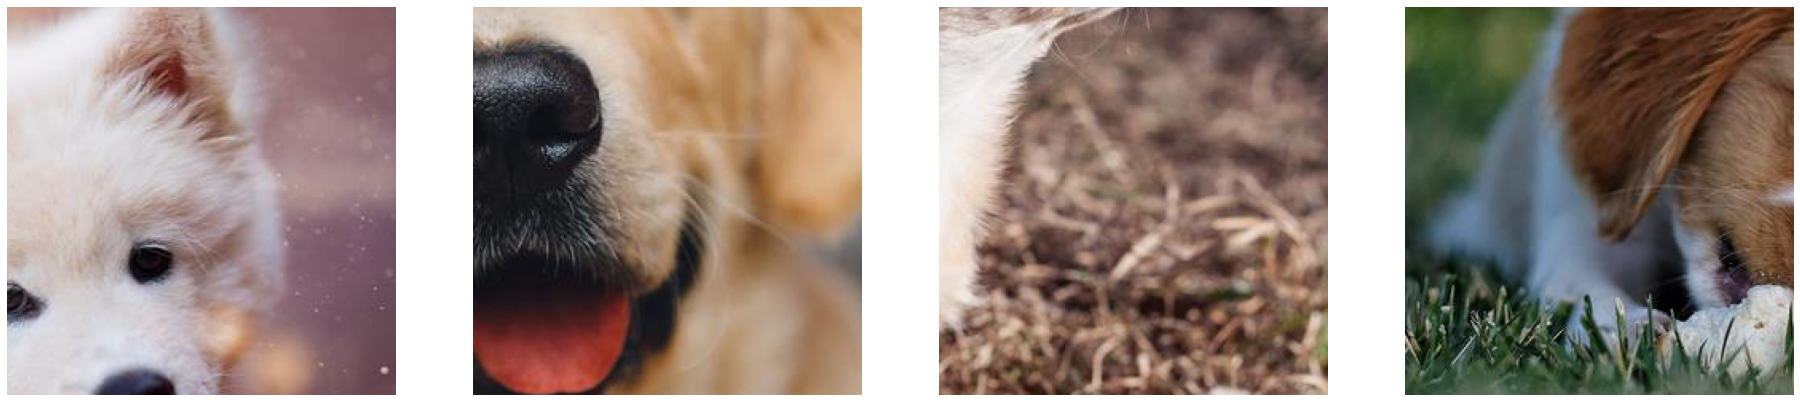

In [8]:
pipe = image_decoder_crop_pipeline(
    batch_size=batch_size, num_threads=1, device_id=0, device="mixed"
)
show_pipeline_output(pipe)

## Image Decoder (Hybrid) with External Window Size and Anchor

`decoders.image_slice` produces a cropped image based on additional tensor inputs describing the cropping window size and position

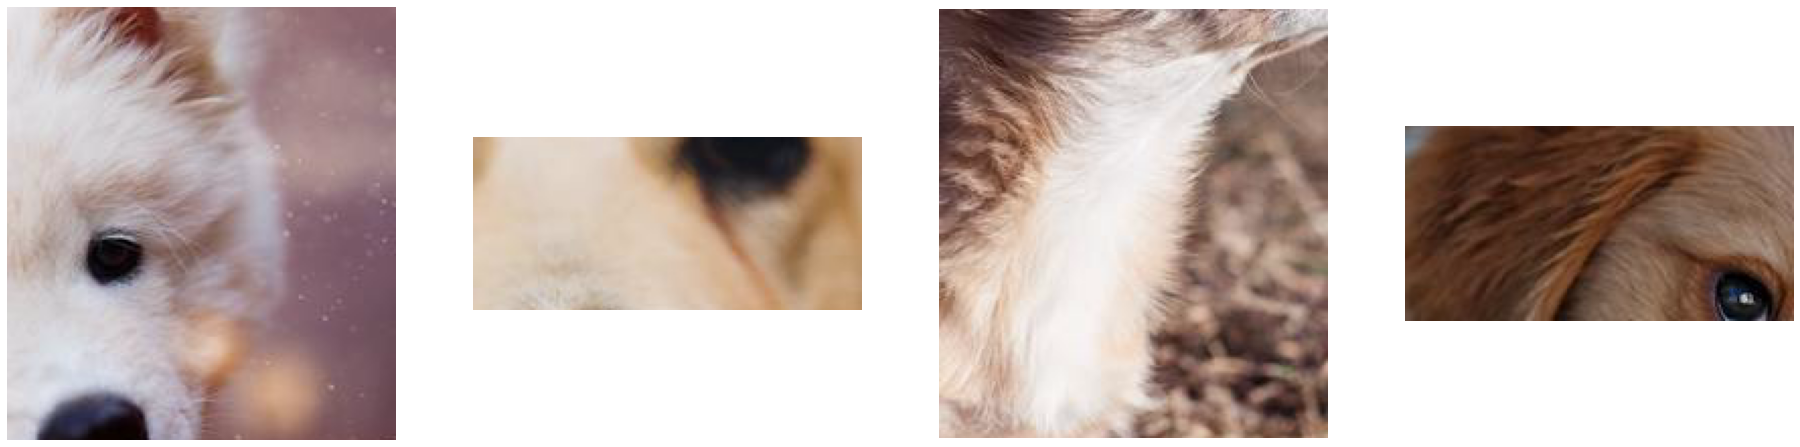

In [9]:
pipe = image_decoder_slice_pipeline(
    batch_size=batch_size, num_threads=1, device_id=0, device="mixed"
)
show_pipeline_output(pipe)